# Time Series Analysis of TESS

This time series analysis of TESS data was an attempt at measuring the rotation period of the M-type star GJ 3942.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.timeseries import LombScargle
import lightkurve as lk
from scipy.optimize import minimize_scalar

## Rotation Period
Our rotation period used is that of a best-fit frequency, while the recorded rotation period is 16.3 days in <a href="https://ui.adsabs.harvard.edu/abs/2017A%26A...608A..63P/abstract">Perger et al. (2021)</a>. Within this time series analysis, a best-fit frequency of 15.7 was found and used. This is best in aligning the average TESS periodogram peaks with the harmonics, which can be seen later in this notebook. The fonts and sizes for plots are also stated here.

In [2]:
# Input Signal (Best-Fit)
rp = 15.7

# Fonts and Sizes
figsize = (9, 5)
title_font = 18
label_font = 14
tick_font = 12

## Functions

Functions were created for:
- processing MAST files
- plotting MAST files as scatter plots
- finding even harmonics
- plotting Lomb-Scargle periodograms
- calculating harmonics for each MAST file
- Convert MAST files into arrays
- Generate a matrix out of arrays of MAST files
- Plot an average of these periodogram arrays.

### MAST Files
Seven MAST files were used from seven sectors from TESS that start on different days. Change the file paths to match those on your machine. This is the information pertaining to each individual MAST file, including start and end times, cadence duration, and sector number. The file name is next to each MAST entry.

 - MAST1: tess2020078014623-s0023-0000000162494287-0177-s
   - sequence_number = 23
   - t_exptime = 120 s
   - t_min = 58927.61640519 (2020-03-19 14:47:37)
   - t_max = 58954.3764166 (2020-04-15 09:02:02)
 - MAST2: tess2022112184951-s0051-0000000162494287-0223-s
   - sequence_number = 51
   - t_exptime = 120 s
   - t_min = 59692.4511093634 (2022-04-23 10:49:35)
   - t_max = 59717.0356530324 (2022-05-18 00:51:20)
 - MAST3: tess2022085151738-s0050-0000000162494287-0222-s
   - sequence_number = 50
   - t_exptime = 120 s
   - t_min = 59664.7717555556 (2022-03-26 18:31:19)
   - t_max = 59691.0108365394 (2022-04-22 00:15:36)
 - MAST4: tess2022138205153-s0052-0000000162494287-0224-s
   - sequence_number = 52
   - t_exptime = 120 s
   - t_min = 59718.1356461806 (2022-05-19 03:15:19)
   - t_max = 59742.5768279167 (2022-06-12 13:50:37)
 - MAST5: tess2022112184951-s0051-0000000162494287-0223-a_fast
   - sequence_number = 51
   - t_exptime = 20 s
   - t_min = 59692.4483316088 (2022-04-23 10:45:35)
   - t_max = 59717.0361159954 (2022-05-18 00:52:00)
 - MAST6: tess2022138205153-s0052-0000000162494287-0224-a_fast
   - sequence_number = 52
   - t_exptime = 20 s
   - t_min = 59718.1356461806 (2022-05-19 03:15:19)
   - t_max = 59742.5772908681 (2022-06-12 13:51:17)
 - MAST7: tess2022085151738-s0050-0000000162494287-0222-a_fast
   - sequence_number = 50
   - t_exptime = 20 s
   - t_min = 59664.7717555556 (2022-03-26 18:31:19)
   - t_max = 59691.0119939468 (2022-04-22 00:17:16)

Where sequence_number is the sector number, t_exptime is the exposure time, t_min is the start time, and t_max is the end time. Within the context of the exposure time, a long cadence is 120 seconds and a short cadence is 20 seconds. This information was retreived from the <a href="https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html">Barbara A. Mikulski Archive for Space Telescopes</a>.

In [3]:
MAST1 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1207/TESS/tess2020078014623-s0023-0000000162494287-0177-s/tess2020078014623-s0023-0000000162494287-0177-s_lc.fits"
MAST2 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1209/TESS/tess2022112184951-s0051-0000000162494287-0223-s/tess2022112184951-s0051-0000000162494287-0223-s_lc.fits" 
MAST3 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1209-2/TESS/tess2022085151738-s0050-0000000162494287-0222-s/tess2022085151738-s0050-0000000162494287-0222-s_lc.fits"
MAST4 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1209-3/TESS/tess2022138205153-s0052-0000000162494287-0224-s/tess2022138205153-s0052-0000000162494287-0224-s_lc.fits"
MAST5 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1209-4/TESS/tess2022112184951-s0051-0000000162494287-0223-a_fast/tess2022112184951-s0051-0000000162494287-0223-a_fast-lc.fits"
MAST6 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1209-5/TESS/tess2022138205153-s0052-0000000162494287-0224-a_fast/tess2022138205153-s0052-0000000162494287-0224-a_fast-lc.fits"
MAST7 = "/Users/andrewandmatthewfonseca/NWelch/GJ3942/TESS_MAST_Files/MAST_2024-03-13T1209-6/TESS/tess2022085151738-s0050-0000000162494287-0222-a_fast/tess2022085151738-s0050-0000000162494287-0222-a_fast-lc.fits"
mast_files = [MAST1, MAST2, MAST3, MAST4, MAST5, MAST6, MAST7]

### Proccessing MAST Files

This function is to process MAST files by grabbing relevant data fields, such as time, flux, and resolution. We also remove any NaN values and sigma clip by 3$\sigma$ to remove outliers caused by flares, which can bias our periodogram at high frequencies.

In [4]:
def process_MAST_file(mast_file_path):
    fits_data = fits.open(mast_file_path)
    data = fits_data[1].data
    time = data.field('TIME')
    pdcsap_flux = data.field('PDCSAP_FLUX')
    time_baseline = time[-1] - time[0]
    resolution = 1 / time_baseline
    #print(resolution)
    
    # Remove NaN values
    indices = np.where(~np.isnan(pdcsap_flux))[0]
    time = time[indices]
    pdcsap_flux = pdcsap_flux[indices]
    
    # Remove outliers (Sigma Clipping)
    std_dev = np.std(pdcsap_flux)
    good_data = np.where(np.abs(pdcsap_flux - np.mean(pdcsap_flux)) < 3 * std_dev)[0]
    time = time[good_data]
    pdcsap_flux = pdcsap_flux[good_data]
    
    return time, pdcsap_flux

### Plotting MAST Files

Here we create scatter plots from the MAST files. With these scatter plots, we can see the potential presence of a signal.

In [5]:
def plot_MAST_file(mast_file_path, sector_num, cadence):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    plt.figure(figsize=figsize)
    plt.scatter(time, pdcsap_flux, alpha=0.1, color='royalblue', marker='.')
    plt.title(f'TESS Sector {sector_num} ({cadence})', fontsize=title_font)
    plt.xlabel('Time (Days)', fontsize=label_font)
    plt.ylabel(r"PDCSAP-Flux (e- s$^{-1}$)", fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.show()

### Harmonics

We create harmonics of any signal that is passed into the function to apply to the Lomb-Scargle periodogram. This function is then repurposed into a harmonics array. We then apply this array to the avearged TESS periodogram later on. We also shade a resolution margin on both sides of the harmonics.

In [6]:
def harmonics(num, mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    time_baseline = time[-1] - time[0]
    resolution = 1 / time_baseline
    for i in np.arange(1, num+1, 1):
        x = i/rp
        plt.axvline(x=x, color='k', linestyle='--', linewidth=0.5)
        plt.fill_between([x - resolution, x + resolution], [1, 1], [1e9, 1e9], color='lightgray', alpha=0.3)

### Harmonics Array

This is the array that we repurposed the previous function for. This will be applyed solely to the average TESS periodogram plot. This function is needed to capture multiple frequnices and serve as a complete representation of the signal's behavior for use in the averaged periodogram. Rather then passing the harmonics function into harmonics_array, this function is limited to a range that captures only the first five resolution lines. These are the peaks within the average periodogram that are used in the time series analysis.

In [7]:
def harmonics_array(num, mast_file_paths):
    for mast_file_path in mast_file_paths:
        time, pdcsap_flux = process_MAST_file(mast_file_path)
        time_baseline = time[-1] - time[0]
        resolution = 1 / time_baseline
        for i in np.arange(1, 6, 1): # To get The first five resolution lines
            x = i/rp
            plt.axvline(x=x, color='k', linestyle='--', linewidth=0.5)
            plt.fill_between([x - resolution, x + resolution], [1, 1], [1e8, 1e8], color='gray', alpha=0.03)

### Calculate and Plot Lomb-Scargle

This function is used to calculate and plot Lomb-Scargle periodograms as semi-log on y-axis. These Lomb-Scargle periodograms are used for characterizing periodic signals in unevenly spaced or irregularly timed data. These will be done for all the sectors present. We also used the harmonics function here to view harmonics of the input signal. The nyquist factor is the multiple of the average nyquist frequency used to choose the maximum frequency. The nyquist factor is set to one because we have a function to find our maximum frequency, as well as other information.

In [8]:
def plot_lomb_scargle(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    frequency, power = LombScargle(time, pdcsap_flux, normalization="psd").autopower(nyquist_factor=1)
    plt.figure(figsize=figsize)
    plt.semilogy(frequency, power, linewidth=2, color='royalblue')
    plt.title('Lomg-Scargle Periodogram', fontsize=title_font)
    plt.xlabel('Frequency (cycle per day)', fontsize=label_font)
    plt.ylabel(r"Power (e-$^{2}$ s$^{-2}$ day)", fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.xlim(0, 1)
    plt.ylim(1e2, 1e9)
    harmonics(rp, mast_file_path)
    plt.show()

### Calculating Frequency

Unlike the harmonics function, we use this function to get the maximum frequnecy, fundamental harmonics, and the maximum period of each MAST file. These are printed out in the 'Plots' section for each MAST file.

In [9]:
def calculate_frequency(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    frequency, power = LombScargle(time, pdcsap_flux, normalization="psd").autopower(nyquist_factor=1)
    max_index = np.argmax(power)
    max_frequency = frequency[max_index]
    max_period = 1 / max_frequency
    harmonic_plus_one = rp / max_period
    return max_frequency, harmonic_plus_one, max_period

### Periodogram Array

Similar to the harmonics_array function, this is solely used for setting all of the MAST periodograms into a single array to then be converted into a two-dimensional matrix in an effort to create an average TESS periodogram.

In [10]:
def generate_periodogram_array(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    f_grid = np.linspace(0, 0.5, num=1024)
    periodogram = LombScargle(time, pdcsap_flux, normalization="psd").power(f_grid)
    return periodogram

### Periodogram Matrix

This is simply to convert the periodogram array into a two-dimensional matrix to then be used in the plotting function for the average periodogram.

In [11]:
def generate_periodogram_matrix(mast_files):
    periodogram_matrix = []
    for mast_file_path in mast_files:
        periodogram = generate_periodogram_array(mast_file_path)
        periodogram_matrix.append(periodogram)
    return np.column_stack(periodogram_matrix)

### Average Peirodogram

This function is used to plot the average TESS periodogram at the end of the 'Plots' section. The peaks at the harmonics possibly give significance towards a 16-day signal.

In [12]:
def plot_average_periodogram(periodogram_array, mast_files):
    f_grid = np.linspace(0, 0.5, num=1024)
    average_periodogram = np.mean(periodogram_array, axis=1)
    plt.figure(figsize=figsize)
    plt.semilogy(f_grid, average_periodogram, color='royalblue', linewidth=2)
    plt.title("Average TESS Periodogram", fontsize=title_font)
    plt.xlabel('Frequency (cycles per day)', fontsize=label_font)
    plt.ylabel(r"Power $[(e^{-}/s)^2 \; \operatorname{day}]$", fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.xlim(0, 0.5)
    plt.ylim(1e6, 1e8)
    harmonics_array(16.3, mast_files)
    plt.show()

## Plots

Here we use all of the above functions to create plots to characterize signals within the TESS data. The first seven are of the different sectors with their Lomb-Scargle plots and relevant information, and then there is the average TESS periodogram.

### MAST1 (Sector 23, Long Cadence)

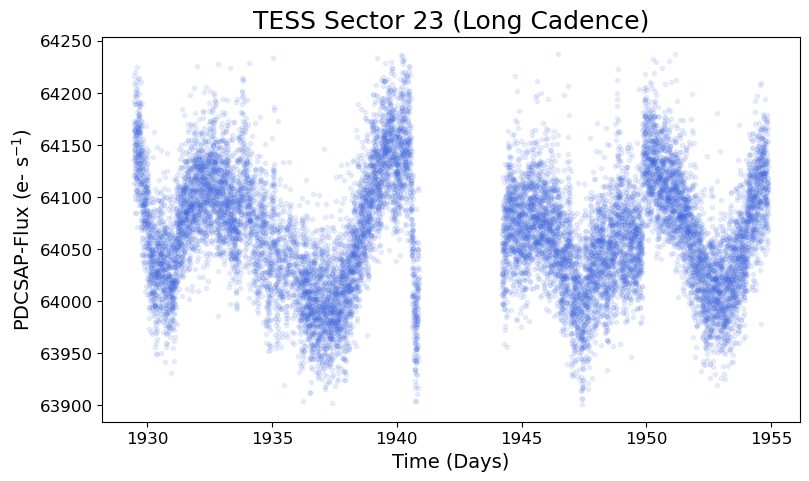

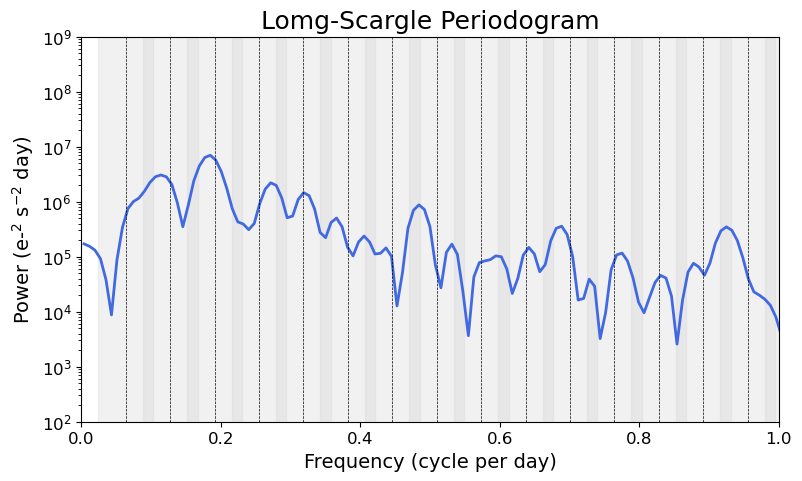

(0.18498682876210162, 2.9042932115649953, 5.405790275404033)

In [13]:
plot_MAST_file(MAST1, 23, 'Long Cadence')
plot_lomb_scargle(MAST1)
calculate_frequency(MAST1)

### MAST2 (Sector 51, Long Cadence)

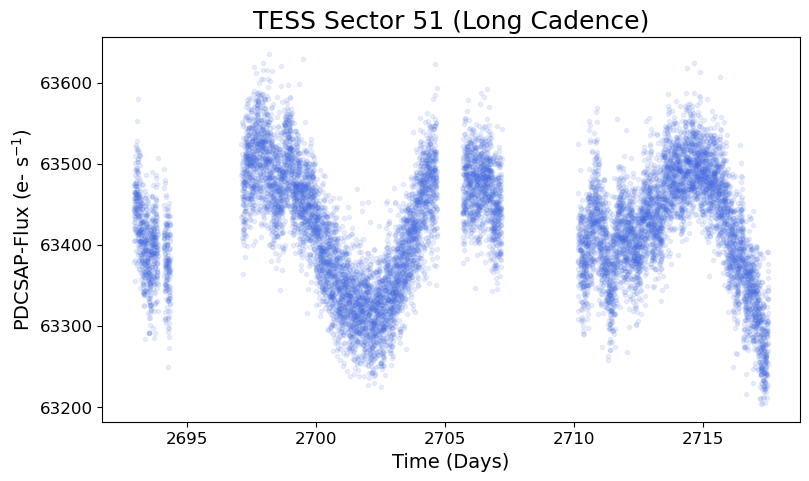

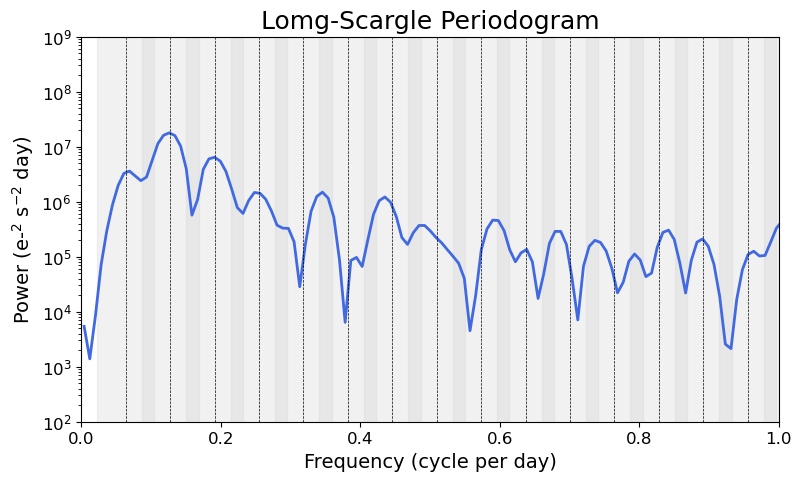

(0.12610260958127134, 1.97981097042596, 7.930050007058055)

In [14]:
plot_MAST_file(MAST2, 51, 'Long Cadence')
plot_lomb_scargle(MAST2)
calculate_frequency(MAST2)

### MAST3 (Sector 50, Long Cadence)

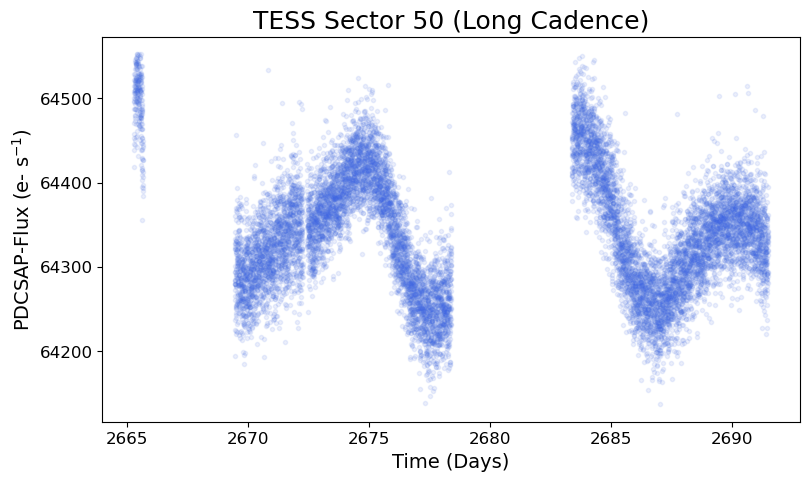

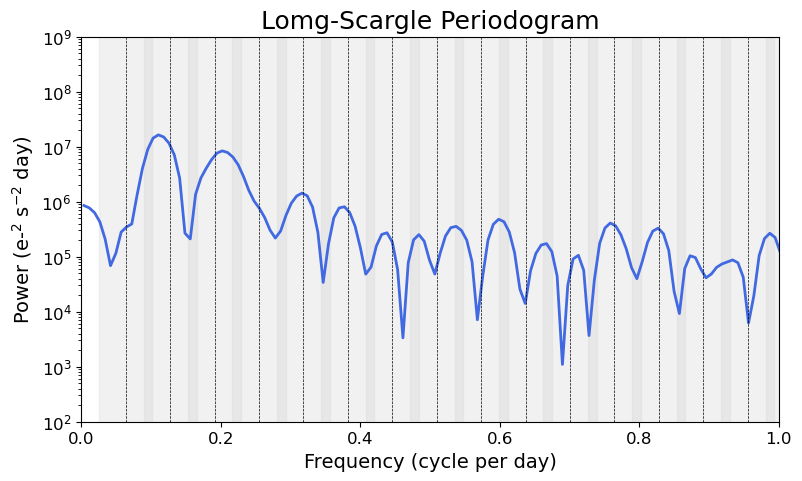

(0.11052801307477737, 1.7352898052740047, 9.04748011097832)

In [15]:
plot_MAST_file(MAST3, 50, 'Long Cadence')
plot_lomb_scargle(MAST3)
calculate_frequency(MAST3)

### MAST4 (Sector 52, Long Cadence)

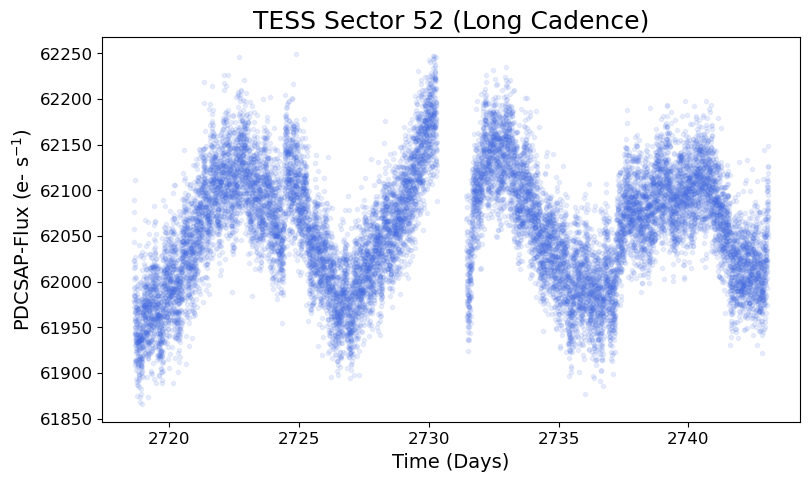

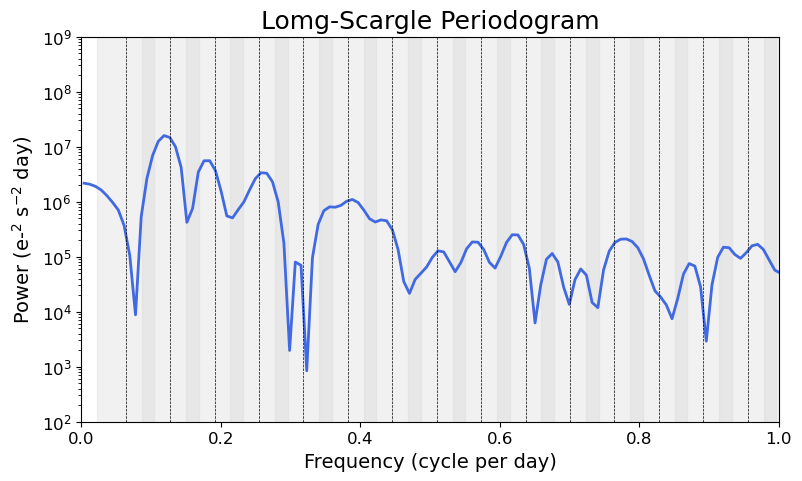

(0.11865894226140021, 1.8629453935039832, 8.427514866911975)

In [16]:
plot_MAST_file(MAST4, 52, 'Long Cadence')
plot_lomb_scargle(MAST4)
calculate_frequency(MAST4)

### MAST5 (Sector 51, Short Cadence)

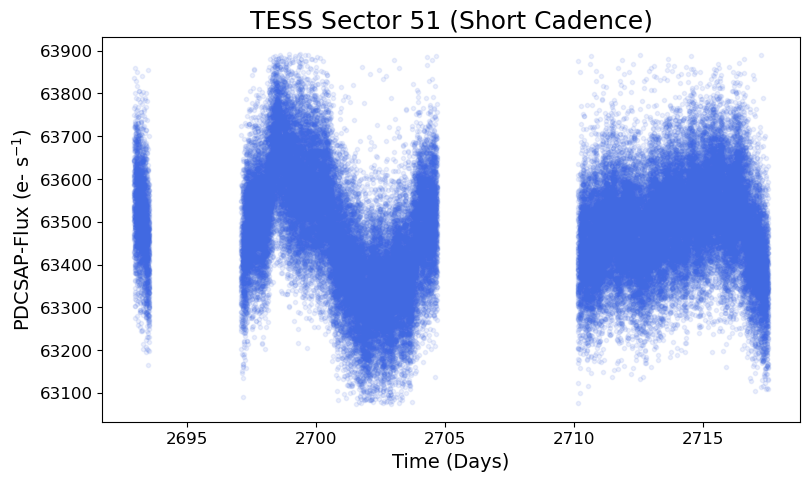

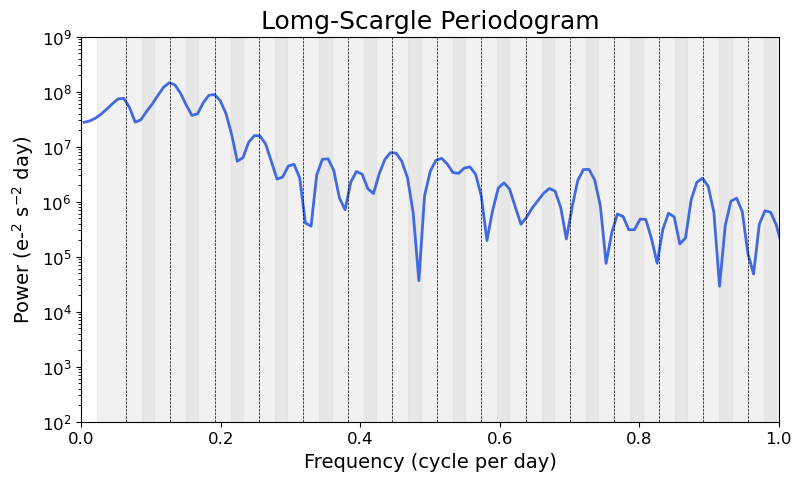

(0.12608005289779825, 1.9794568304954323, 7.931468753511787)

In [17]:
plot_MAST_file(MAST5, 51, 'Short Cadence')
plot_lomb_scargle(MAST5)
calculate_frequency(MAST5)

### MAST6 (Sector 52, Short Cadence)

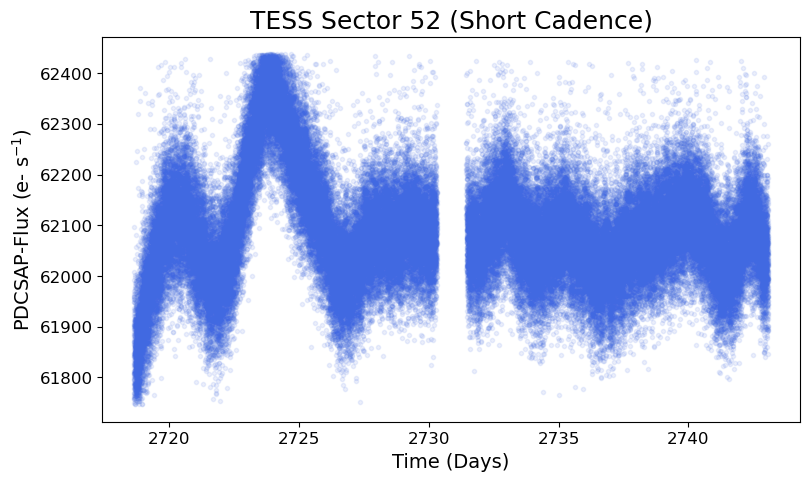

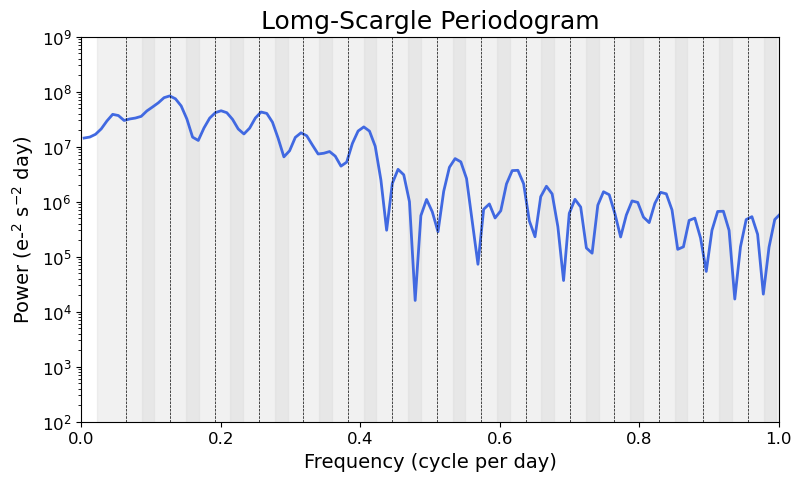

(0.12683390863007146, 1.991292365492122, 7.884326918573782)

In [18]:
plot_MAST_file(MAST6, 52, 'Short Cadence')
plot_lomb_scargle(MAST6)
calculate_frequency(MAST6)

### MAST7 (Sector 50, Short Cadence)

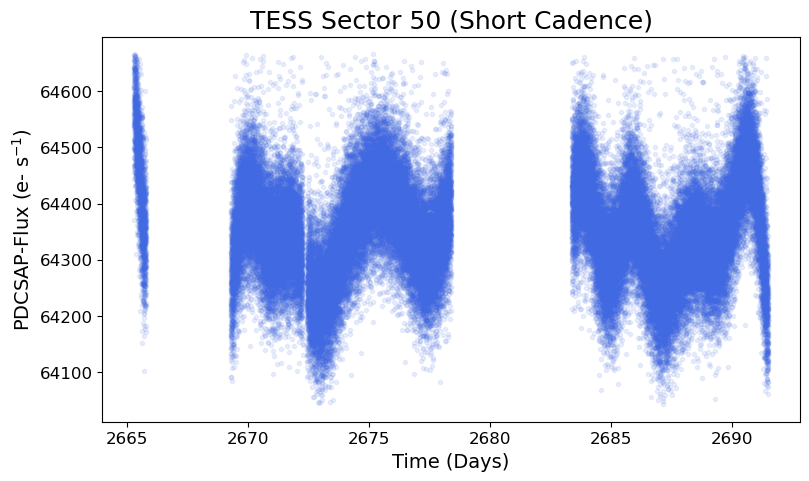

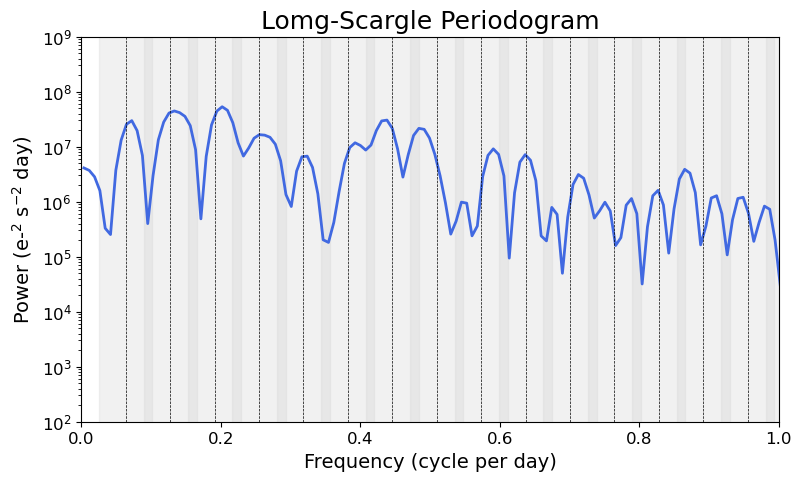

(0.20198343418724568, 3.171139916739757, 4.950901067822053)

In [19]:
plot_MAST_file(MAST7, 50, 'Short Cadence')
plot_lomb_scargle(MAST7)
calculate_frequency(MAST7)

### Average Lomb-Scargle Periodogram

This is the average Lomb-Scargle Periodogram that encompasses the seven sectors that were used above. This compiles all the MAST files into a matrix called periodogram_array to then be plotted, along with resolution lines up to the fifth relevant peak.

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: divide by zero encountered in divide
  power = YC * YC / CC + YS * YS / SS
/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS


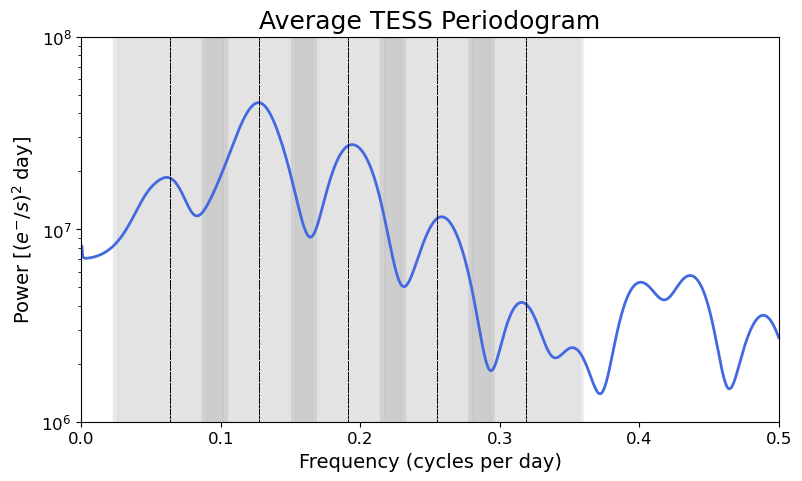

In [20]:
periodogram_array = generate_periodogram_matrix(mast_files)
plot_average_periodogram(periodogram_array, mast_files)

## Best Fit Frequency

Using the TESS data, we try and find a best-fit frequency by using the first derivative of the average TESS periodogram made in the above section.

## Functions

Functions were created for:
- Calculating the first derivative
- Finding local maxima
- Creating relevant variables
- Plotting the first derivative
- Create a objective function
- Find the best-fit frequency

### Calculating First Derivative

Using the average TESS periodogram, we calculate the first derivative and return it to use in later functions to find the best-fit frequency.

In [21]:
def calculate_first_derivative(periodogram, delta_f):
    N = len(periodogram)
    first_derivative = np.zeros(N)
    
    for i in range(1, N-1):
        first_derivative[i] = (periodogram[i+1] - periodogram[i-1]) / (2 * delta_f)
        
    return first_derivative

### Finding Local Maxima

Using the first derivative, we try to find the local maxima at a cutoff of a absolute value of the first derivative that is closest to zero.

In [22]:
def find_local_maxima(f_grid, derivative):
    abs_derivative = np.abs(derivative)
    local_maxima = np.where((abs_derivative[:-2] > abs_derivative[1:-1]) &
                            (abs_derivative[1:-1] < abs_derivative[2:]))[0] + 1
        
    return local_maxima

### Relevant Variables

This is where we create relevant variables to be used in the functions ahead. This includes creating a new average TESS periodogram, as well as the first derivative, local maxima, and delta f from the functions stated above.

In [23]:
# Average TESS periodogram
periodogram_matrix = generate_periodogram_matrix(mast_files)
f_grid = np.linspace(0, 0.5, num=1024)
average_periodogram = np.mean(periodogram_matrix, axis=1)

# Creating delta f, first derivative, and local maxima variables
delta_f = f_grid[1] - f_grid[0]
first_derivative = calculate_first_derivative(average_periodogram, delta_f)
local_maxima = find_local_maxima(f_grid, first_derivative)

### Plotting First Derivative

Here we plot the first derivative of the average TESS periodogram. Using the local maxima from above, we get every other local maxima while skipping near-zero frequencies. 

In [24]:
def plot_first_derivative(f_grid, first_derivative, local_maxima):
    plt.figure(figsize=figsize)
    plt.plot(f_grid, np.abs(first_derivative))
    
    if len(local_maxima) > 0:
        select_maxima_indices = local_maxima[1:10:2]
        plt.scatter(f_grid[select_maxima_indices], np.abs(first_derivative)[select_maxima_indices], color='red', label='Local Maxima')
        
    plt.title("1st Derivative of Average Periodogram", fontsize=title_font)
    plt.xlabel('Frequency (cycles per day)', fontsize=label_font)
    plt.ylabel('Absolute Value of 1st Derivative', fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.legend()
    plt.show()

### Objective Function

This objective function is used as to get the difference between a set of harmonic frequencies and the rotation frequency (period) of a signal to then minimize that difference. This is for optimization of the fit.

In [25]:
def objective_function(period, harmonic_freq):
    frequency = 1 / period
    array = np.arange(len(harmonic_freq)) + 1
    var = harmonic_freq - frequency * array
    return np.sum(var**2)

### Finding Best-Fit Frequency

Here is where we find the best-fit frequency through a ceratin maxima indices and minimizing it using the objective function, along with the minimize_scalar. This minimize_scalar is a function in the imported scipy.optimize module.

In [26]:
def find_best_fit_frequency(f_grid):
    select_maxima_indices = local_maxima[1:10:2]
    result = minimize_scalar(objective_function, args=(f_grid[select_maxima_indices]), bounds=(14.5, 17.5), method='bounded')
    return result.x

## First Derivative Plot

This plot shows the first derivative of the average TESS periodogram. It shows the local maxima that correspond to the five peaks in the average TESS periodogram with resolution margins. Underneath the plot is the best-fit frequency using the find_best_fit_frequency function.

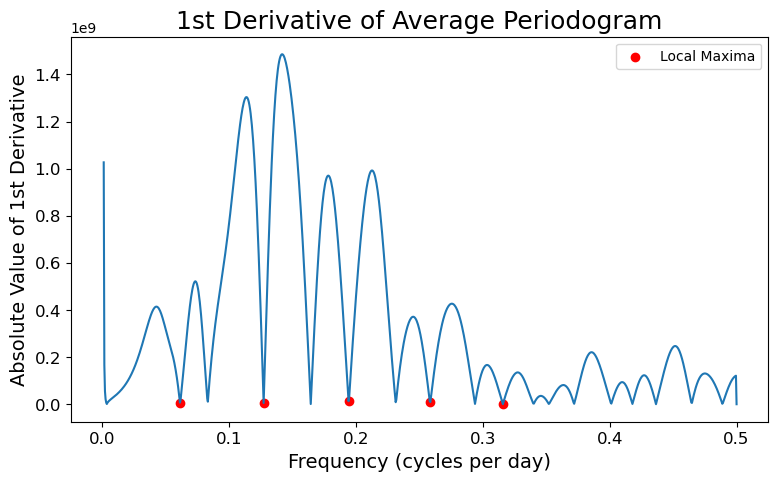

In [27]:
plot_first_derivative(f_grid, first_derivative, local_maxima)

In [28]:
best_frequency = find_best_fit_frequency(f_grid)
print("Best Fit Frequency: ", best_frequency)

Best Fit Frequency:  15.668337508310247


## Sources

Data Tables:
 - https://exoplanetarchive.ipac.caltech.edu/overview/GJ%203942
 - https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html


Filter:
 - http://svo2.cab.inta-csic.es/theory/fps/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS#filter